<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_positive_rate_etc_by_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

0      1         2   ...                          10         11      12
0      Date  State  Positive  ...  On Ventilator – Cumulative  Recovered  Deaths
1  20200429     AK       355  ...                                    240       9
2  20200429     AL     6,842  ...                         195                245
3  20200429     AR     3,192  ...                          82       1249      59
4  20200429     AS         0  ...                                              0

[5 rows x 13 columns]

In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='coerce')
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['Total'] = full_df.Positive+full_df.Negative.fillna(0)  # New definition
full_df['posrate'] = full_df.Positive / full_df.Total

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MA', 'IL', 'CA', 'PA', 'MI', 'FL', 'LA', 'TX', 'CT',
       'GA', 'MD', 'OH', 'IN', 'VA', 'CO', 'WA', 'TN', 'NC', 'RI', 'MO',
       'AZ', 'IA', 'AL', 'MS', 'WI', 'SC', 'NV', 'DE', 'MN', 'UT', 'KY',
       'DC', 'KS', 'OK', 'NE', 'AR', 'NM', 'OR', 'SD', 'NH', 'ID', 'PR',
       'WV', 'ME', 'ND'], dtype=object)

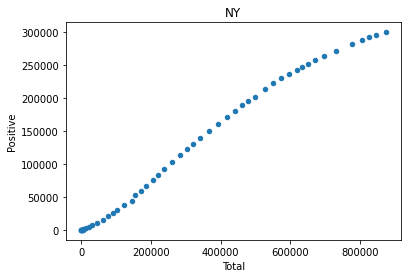

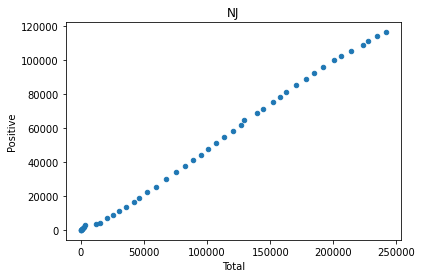

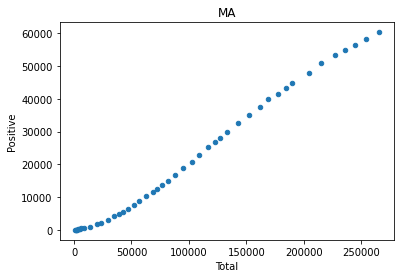

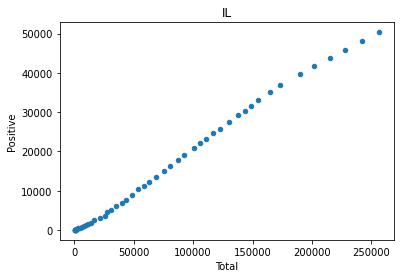

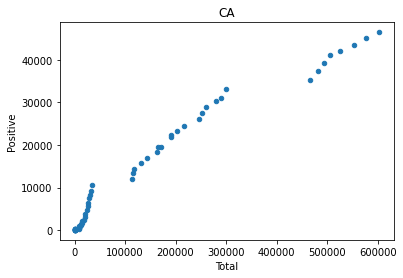

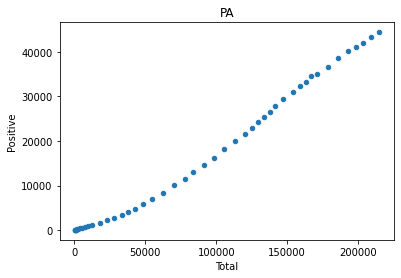

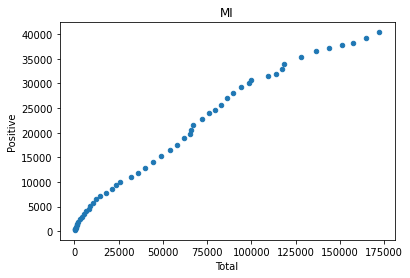

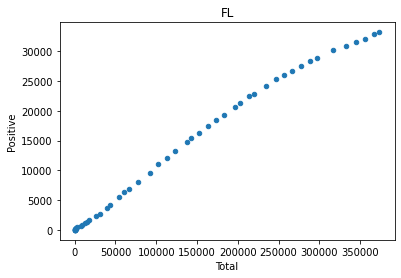

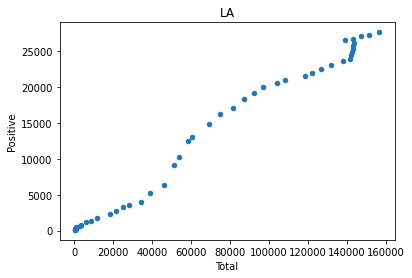

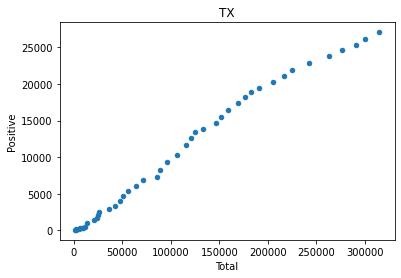

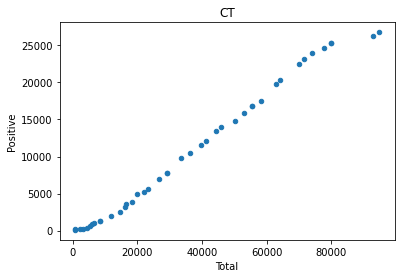

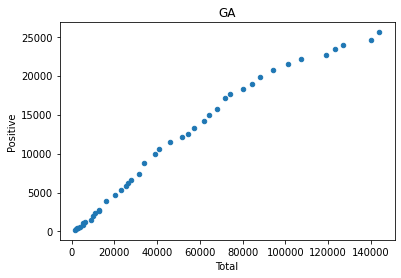

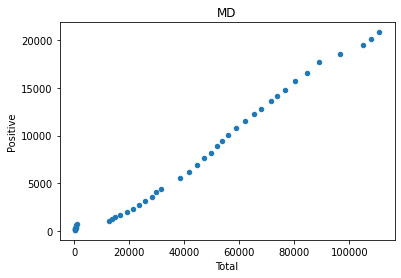

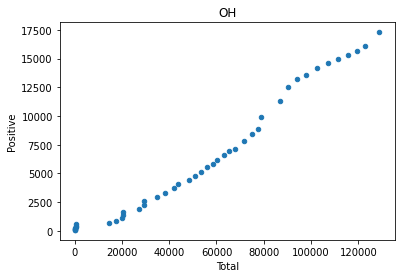

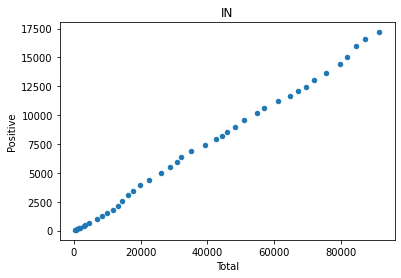

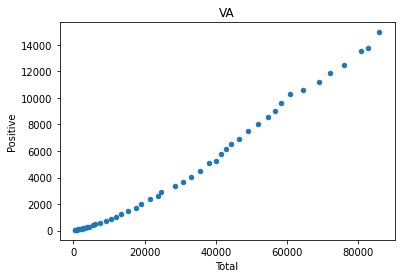

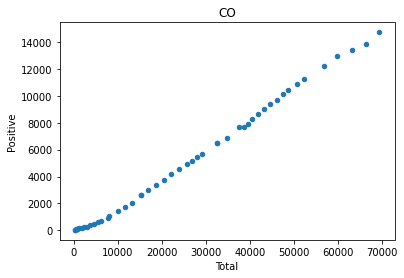

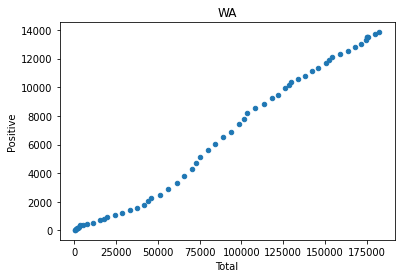

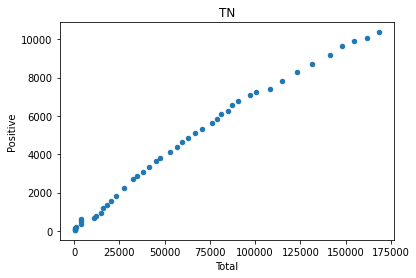

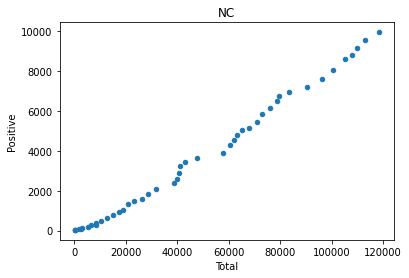

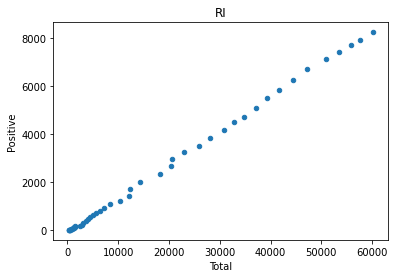

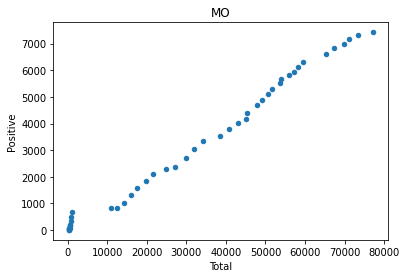

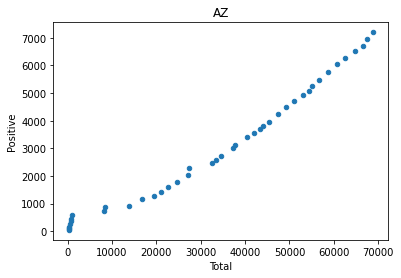

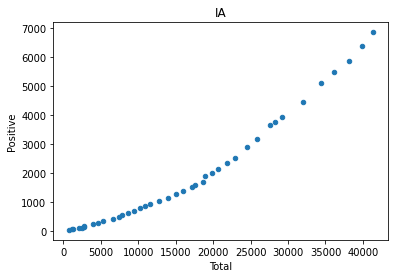

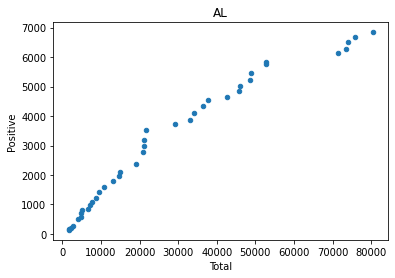

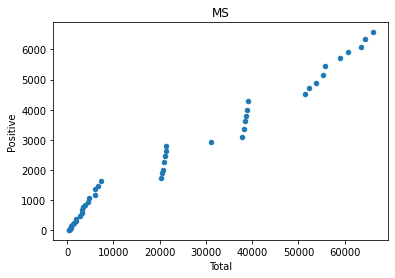

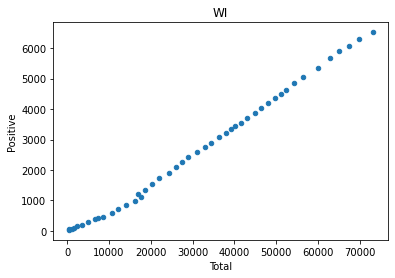

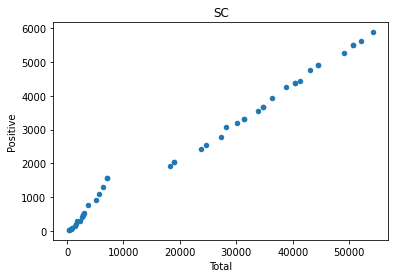

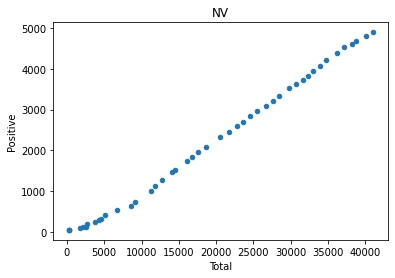

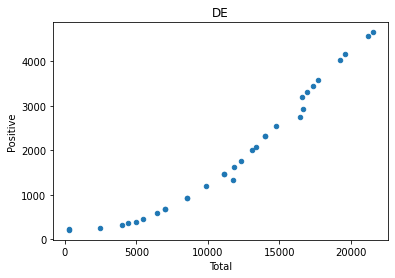

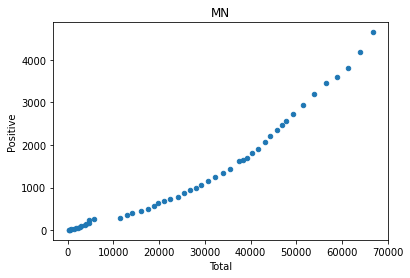

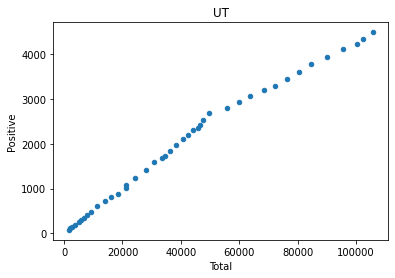

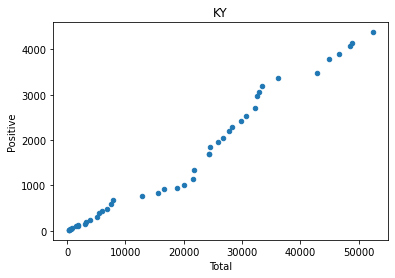

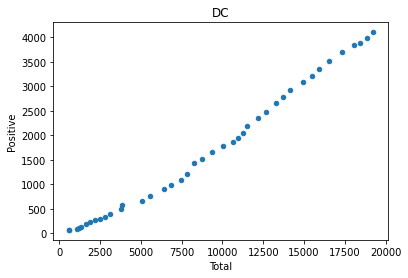

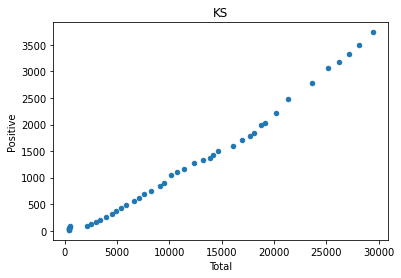

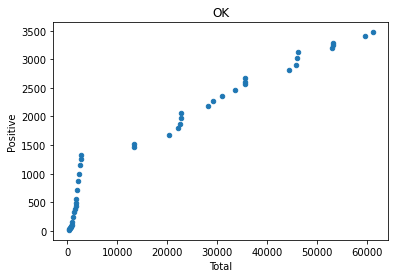

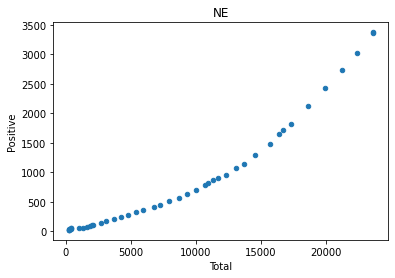

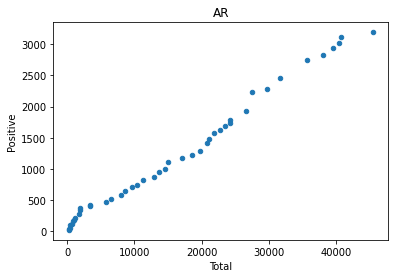

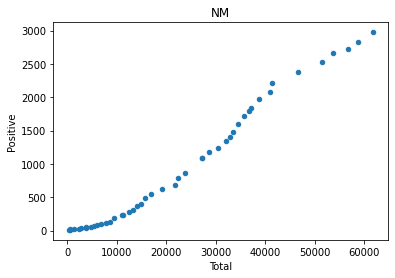

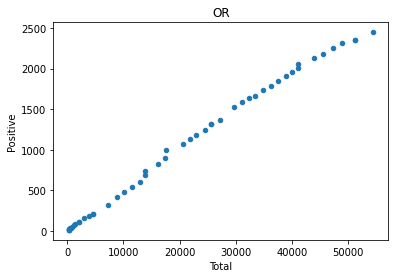

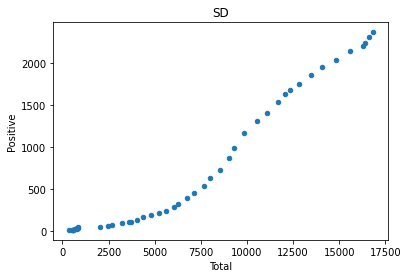

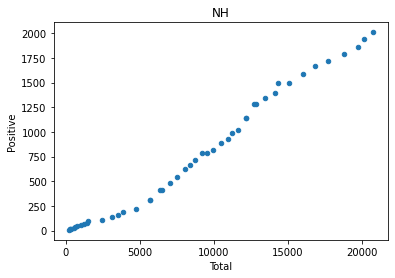

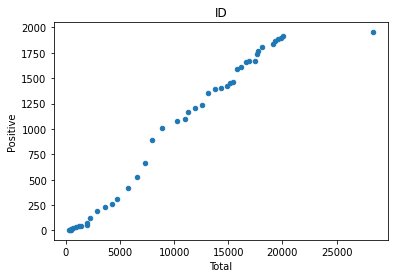

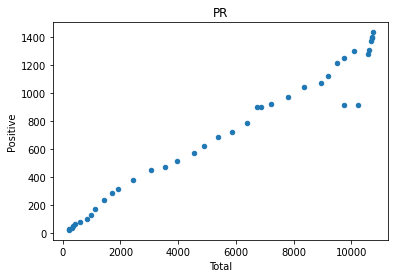

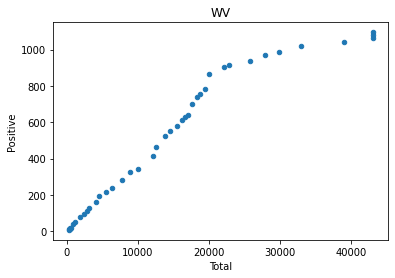

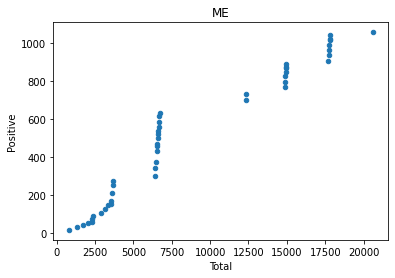

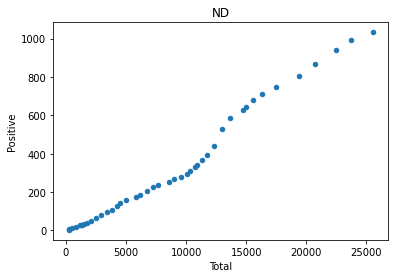

In [11]:
# Scatterplot  "Number of positive tests (confirmed cases)" 
#          vs. "Total number of cumulative tests"  (by state)

# We hope (but thus far do not find) that these plots will eventually start
#   to look like concave functions.  In other words, states should be testing
#   more and more people and hoping that, as testing is broadened, they find
#   a smaller proportion of infections among those tested.

for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

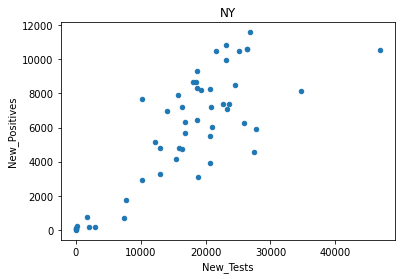

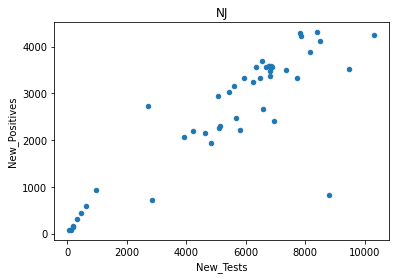

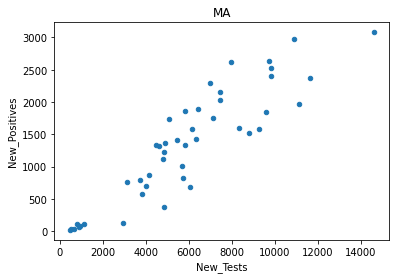

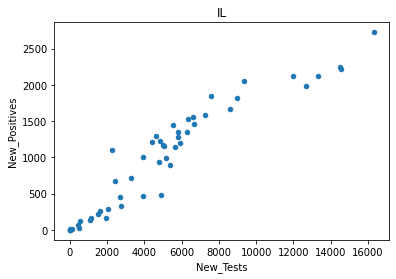

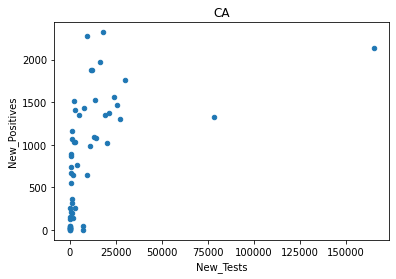

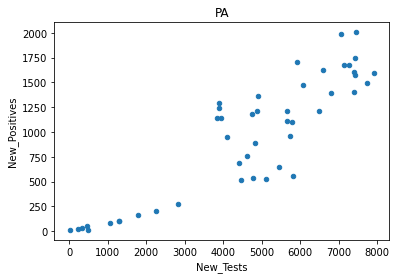

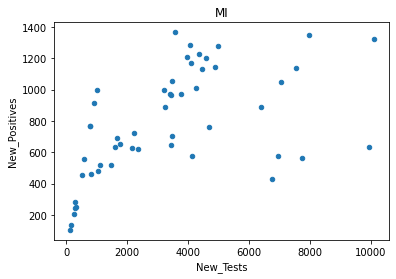

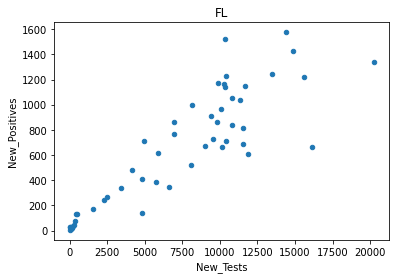

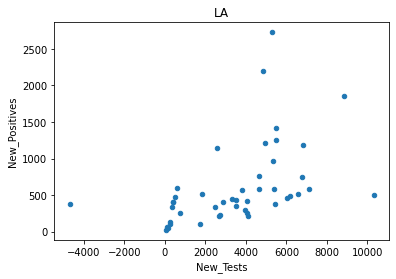

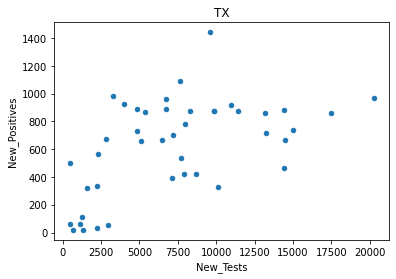

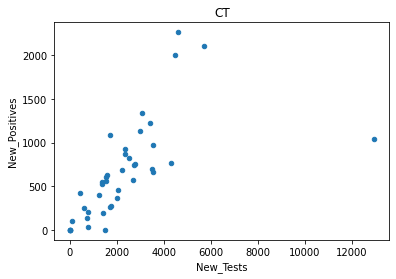

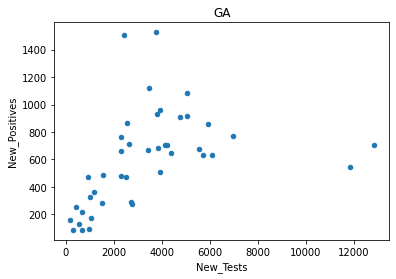

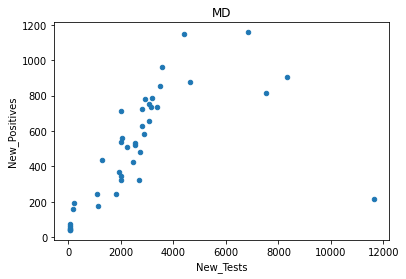

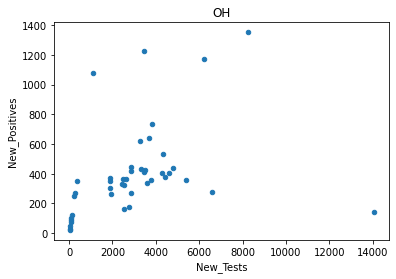

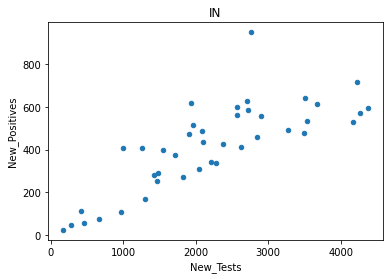

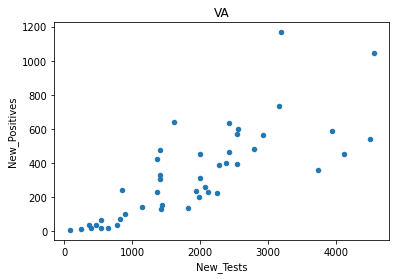

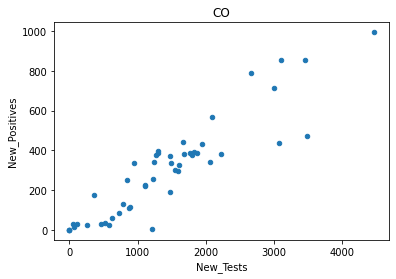

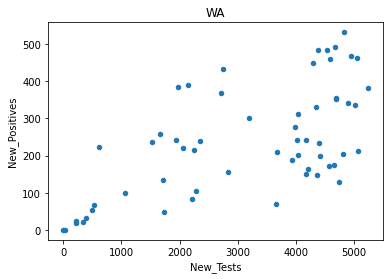

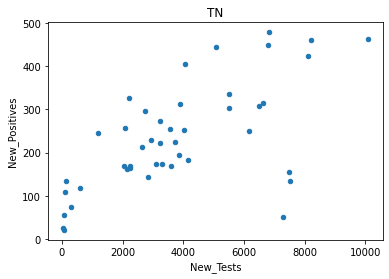

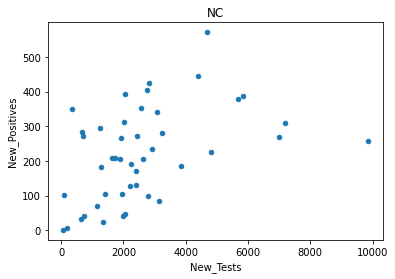

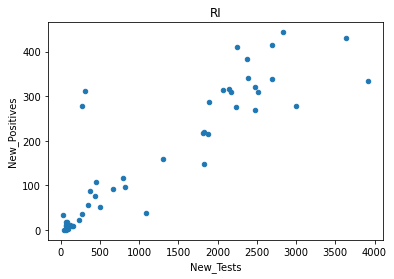

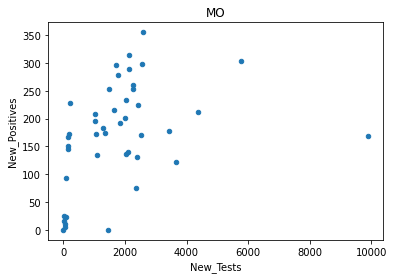

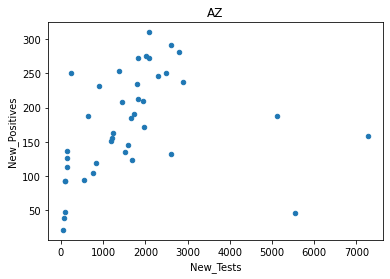

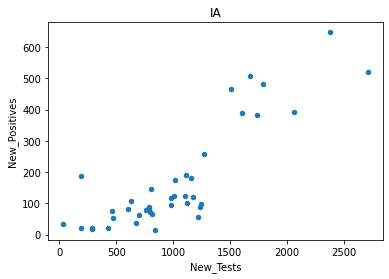

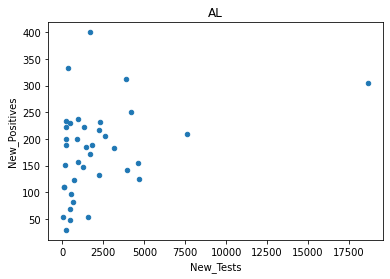

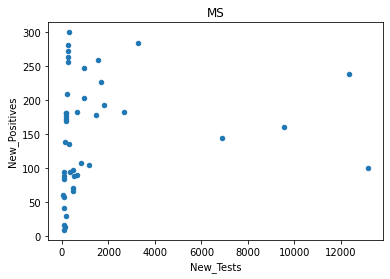

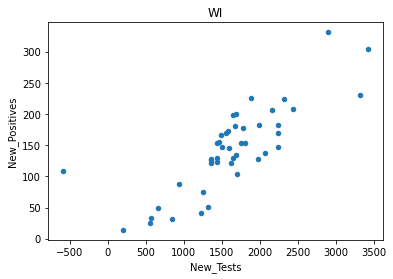

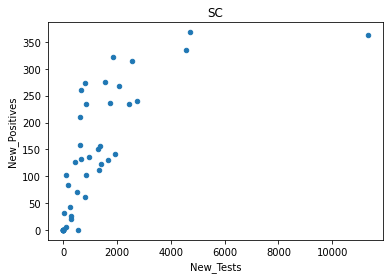

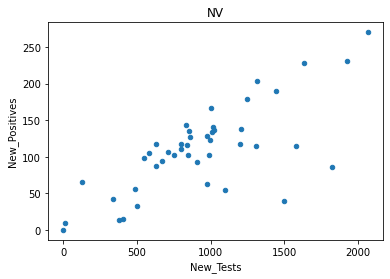

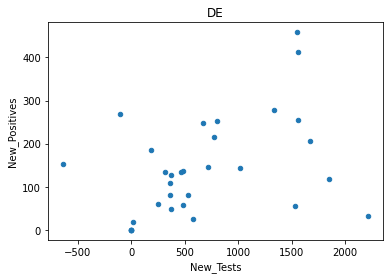

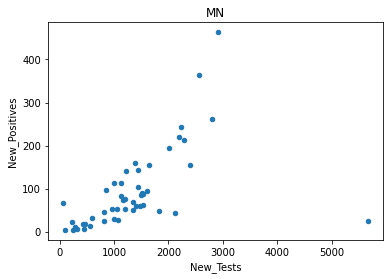

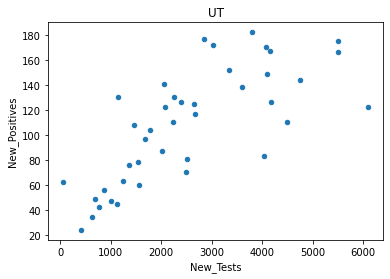

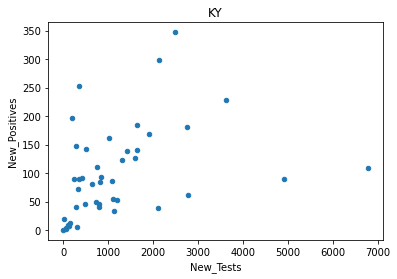

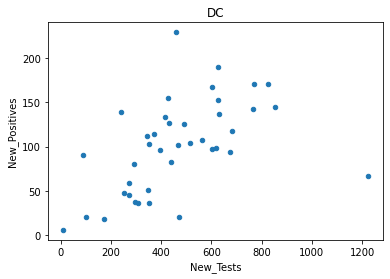

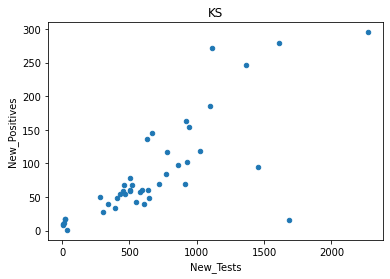

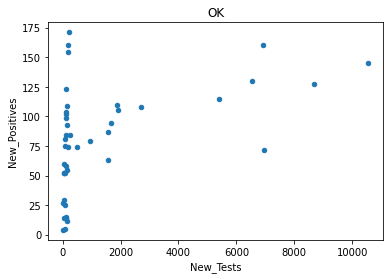

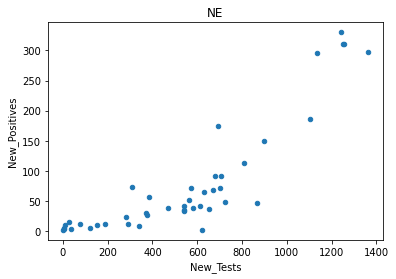

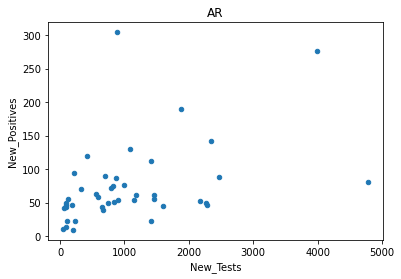

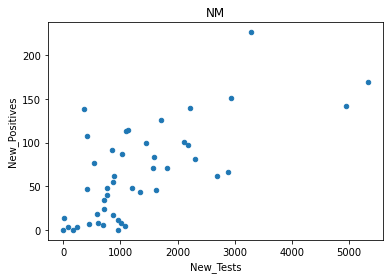

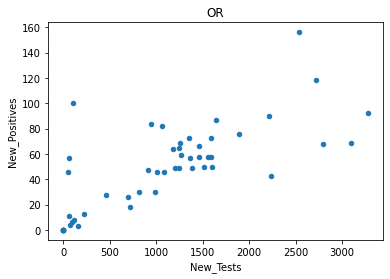

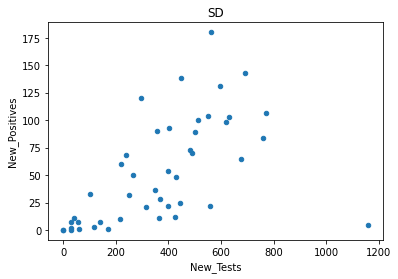

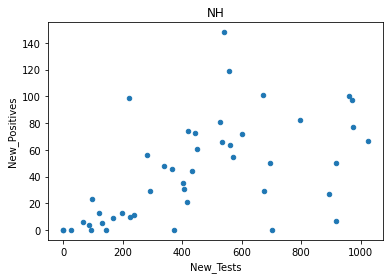

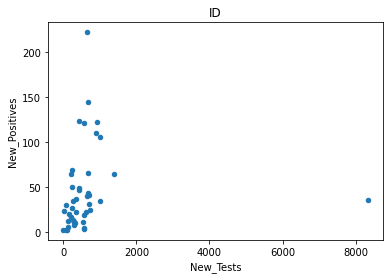

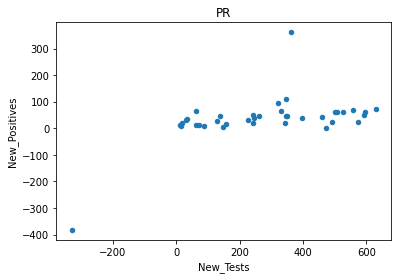

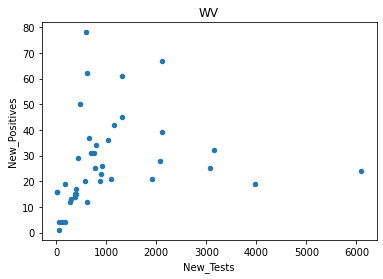

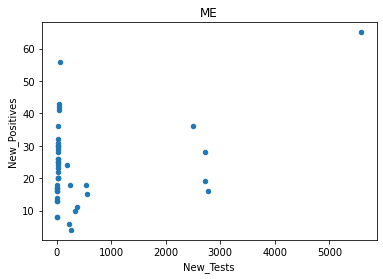

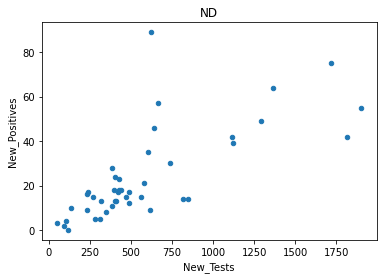

In [12]:
# Scatterplot  "Number of NEW positive tests (latest confirmed cases)" 
#          vs. "Total number of NEW tests"   (by state)

# We hope (but thus far do not find) that these will eventually flatten out.
#   Again, states should be testing more and more people and hoping that, 
#   as testing is broadened, they find a smaller proportion test positive.

for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Tests'] = -df['Total'].diff()
  df['New_Positives'] = -df['Positive'].diff()
  df[df.Total>200][['New_Tests','New_Positives']].plot(kind='scatter', 
                                                       x='New_Tests', 
                                                       y='New_Positives', 
                                                       title=state)
  plt.show()

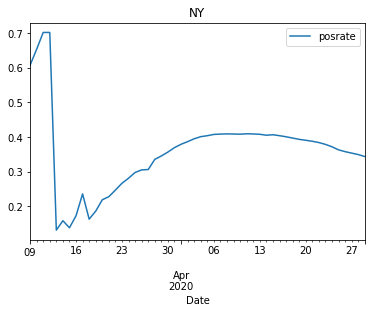

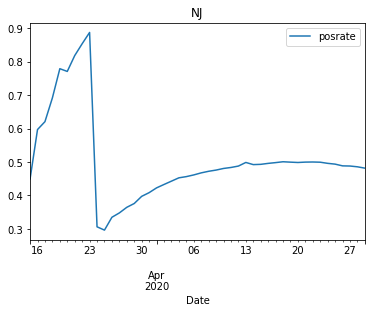

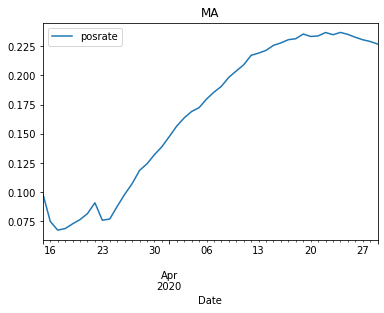

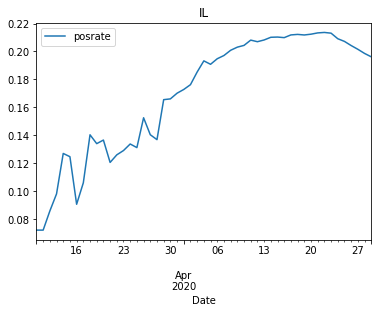

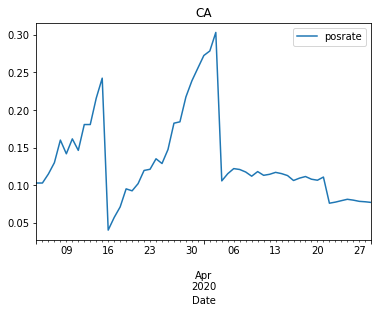

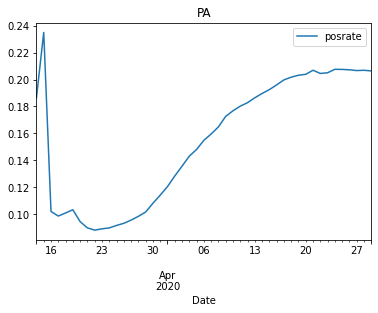

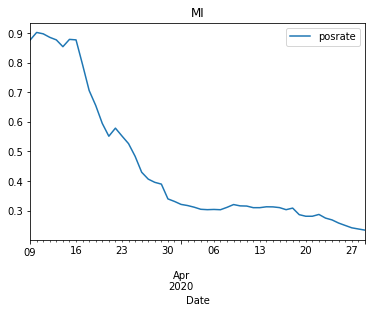

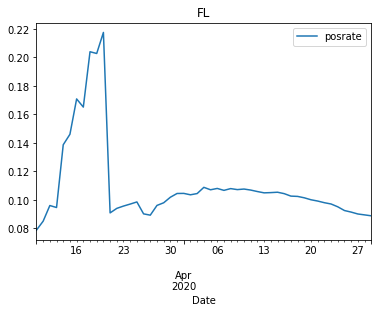

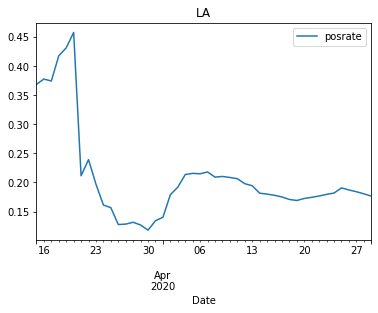

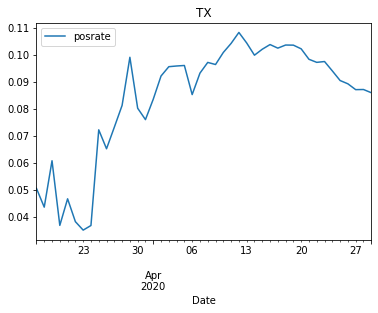

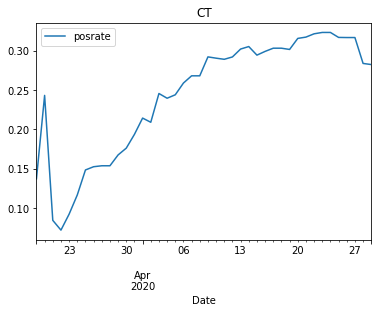

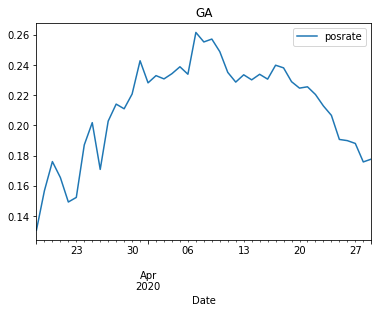

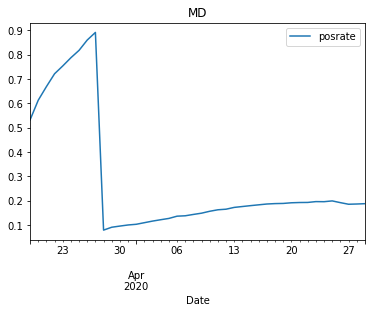

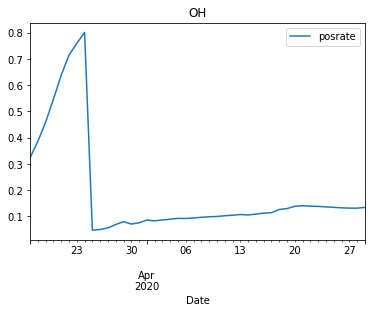

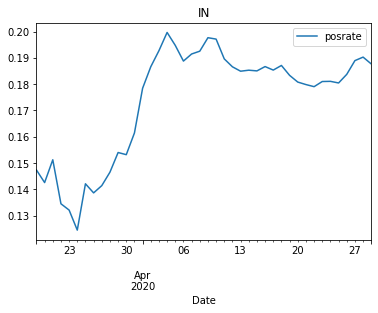

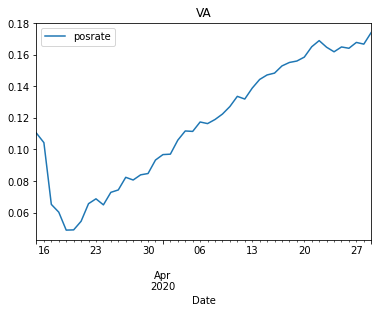

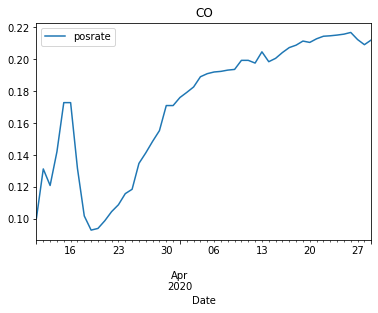

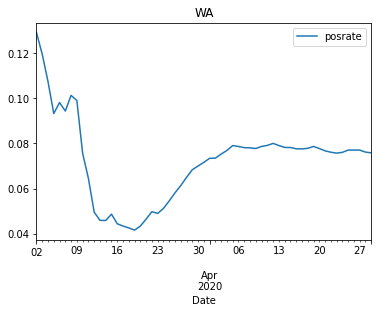

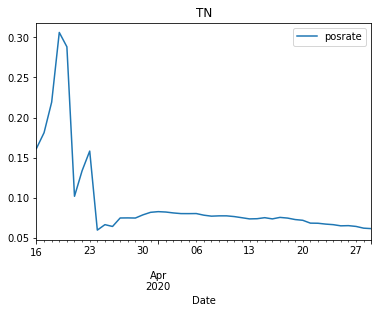

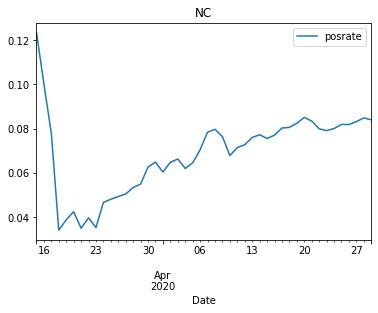

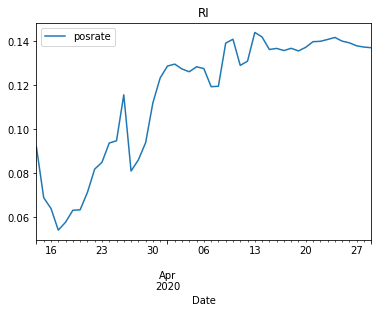

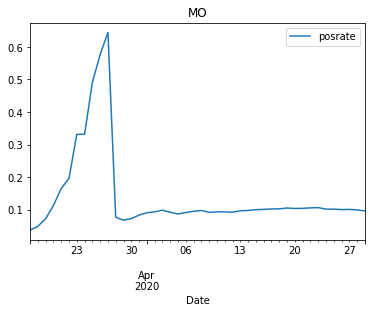

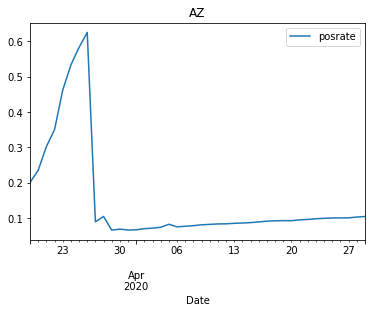

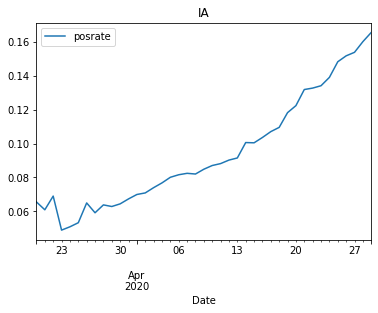

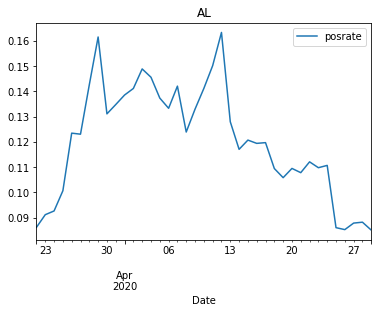

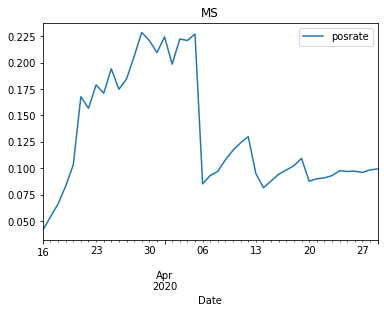

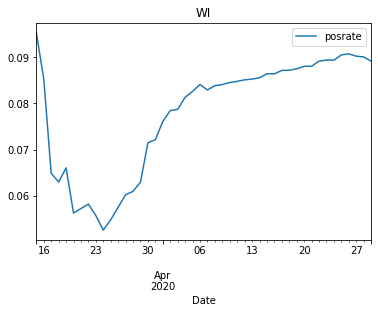

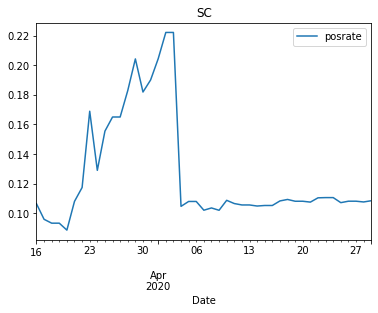

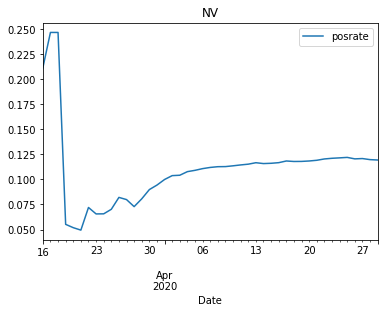

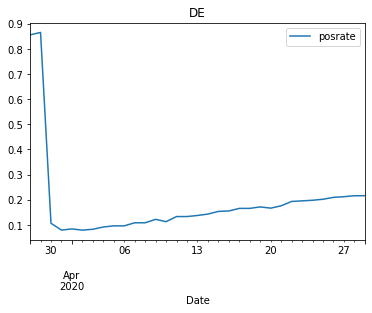

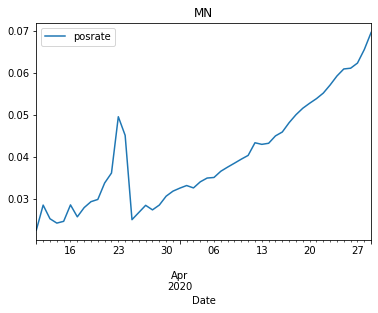

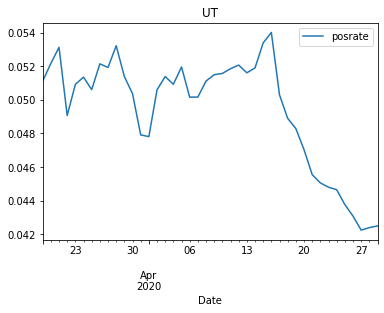

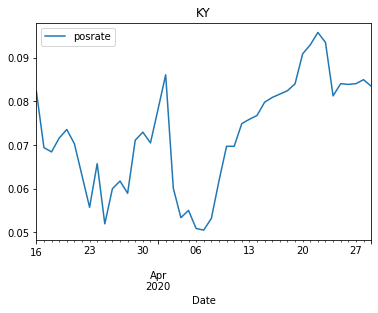

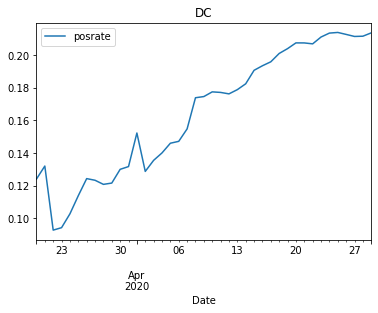

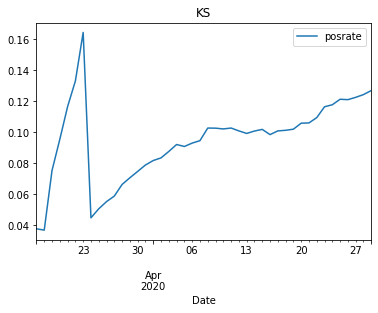

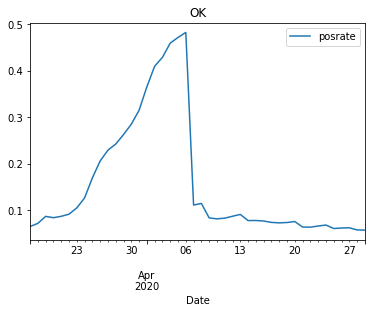

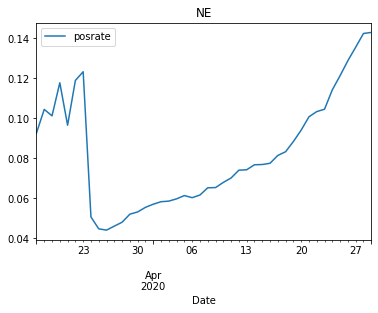

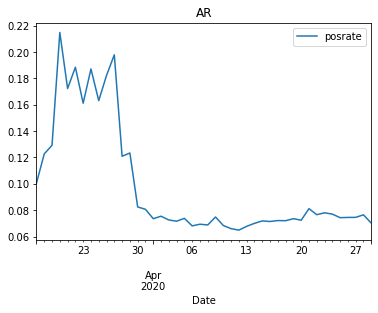

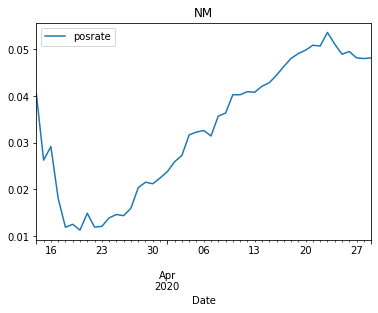

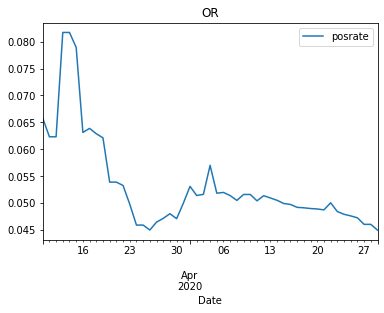

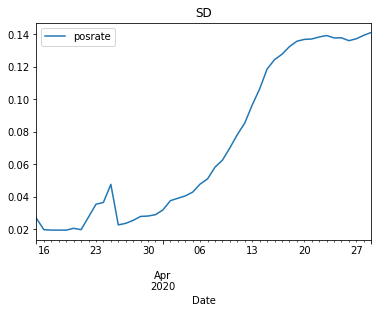

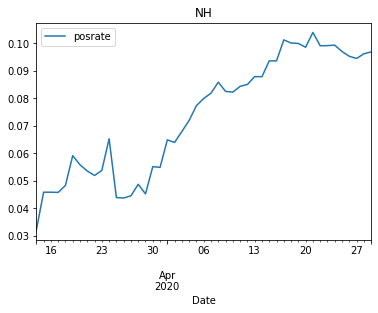

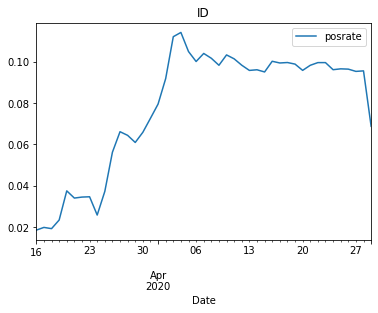

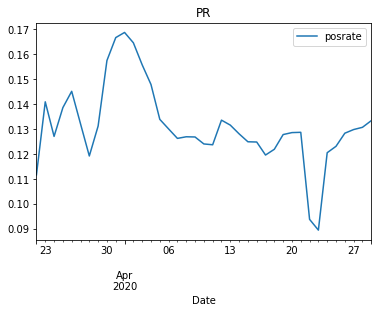

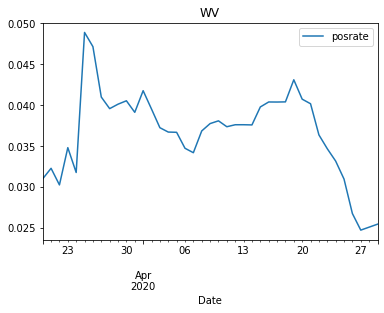

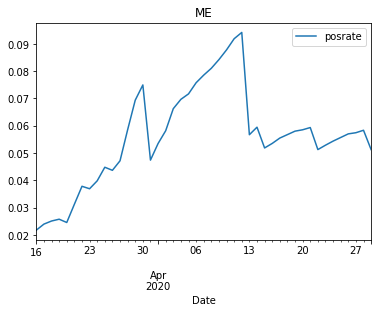

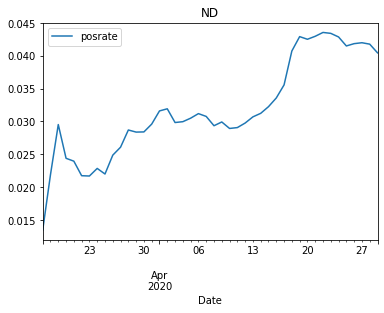

In [13]:
# Plot time series of fraction of tests that are positive (by state)
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

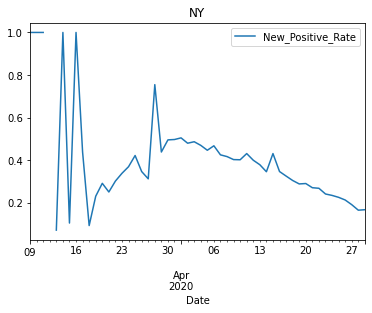

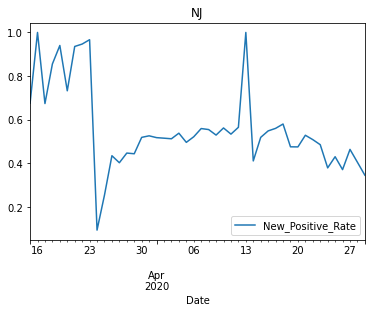

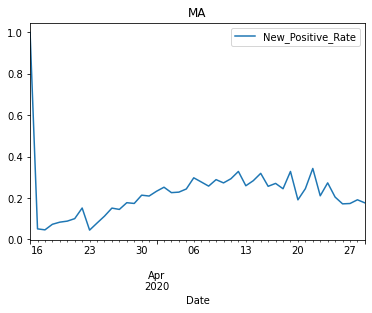

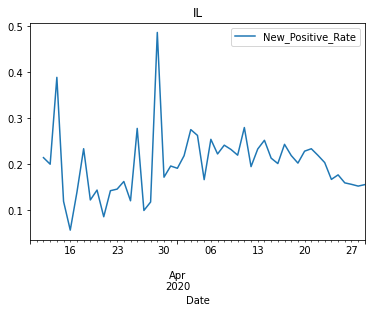

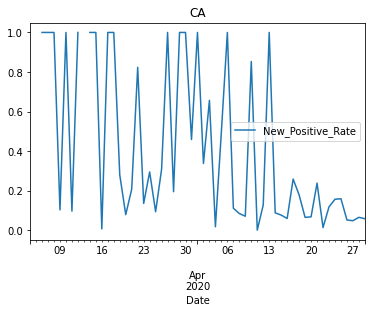

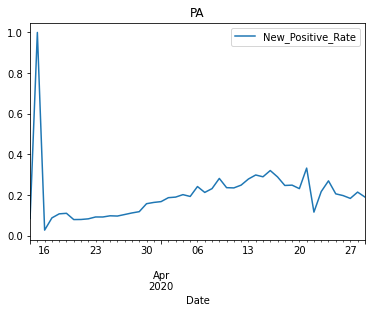

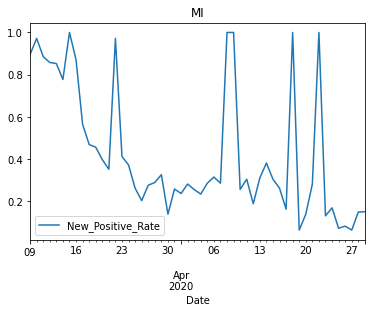

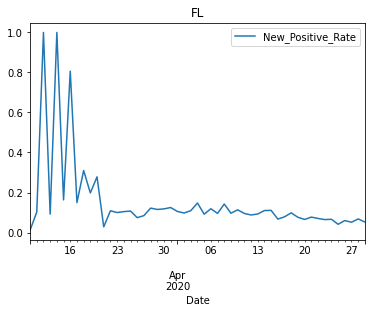

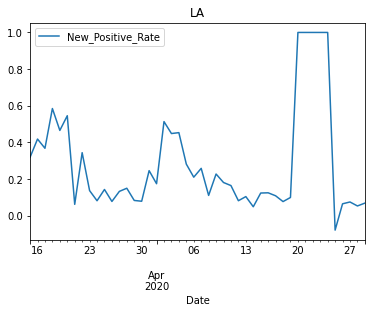

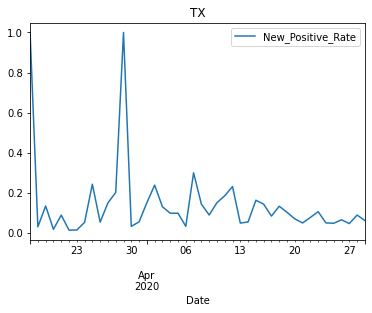

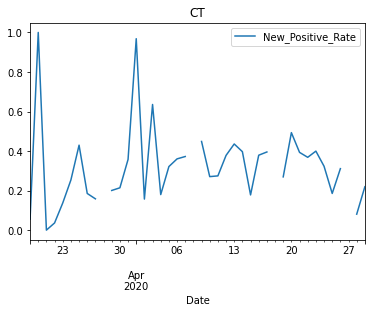

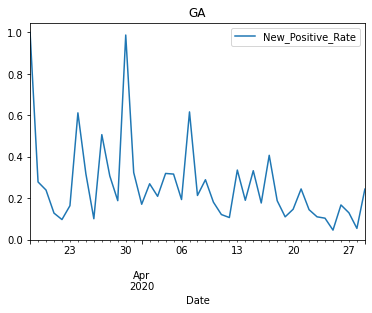

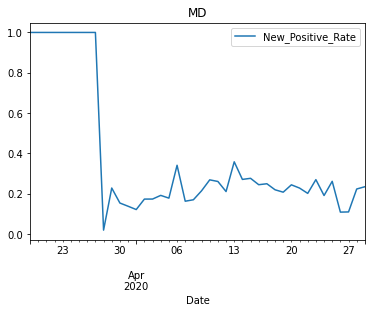

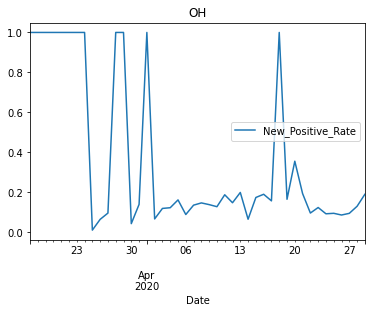

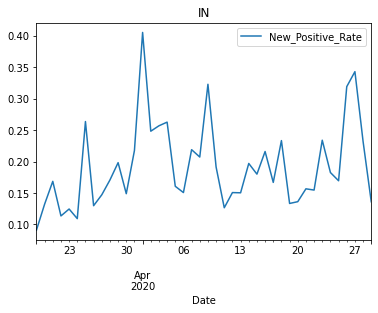

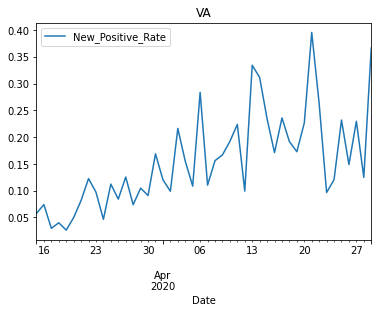

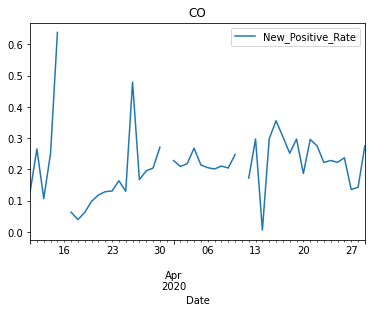

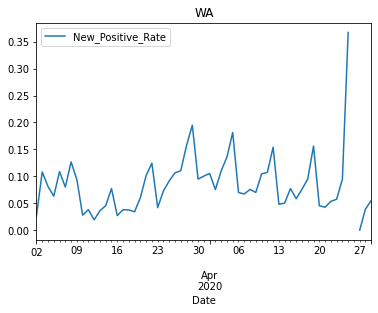

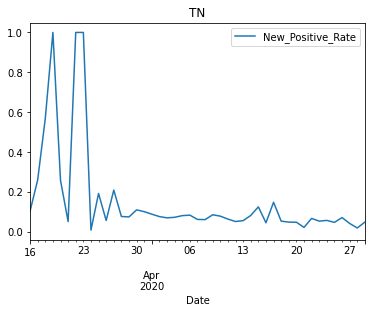

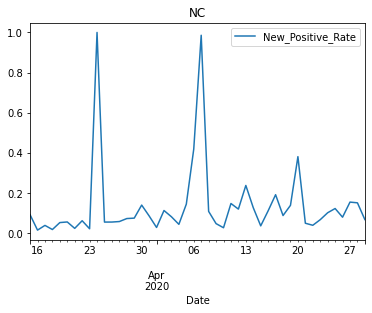

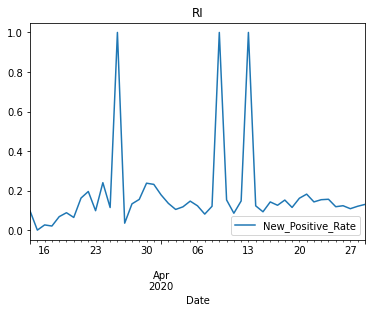

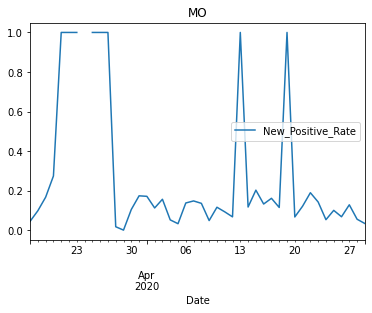

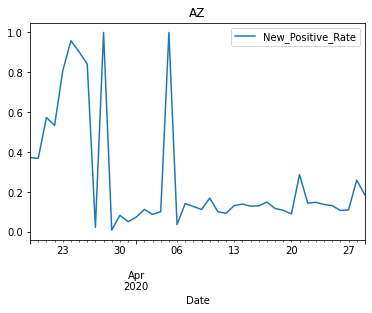

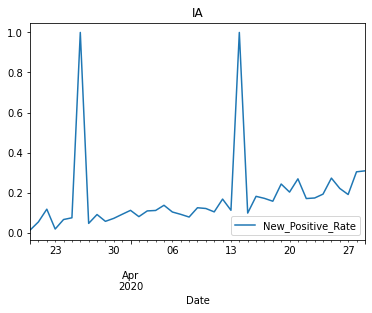

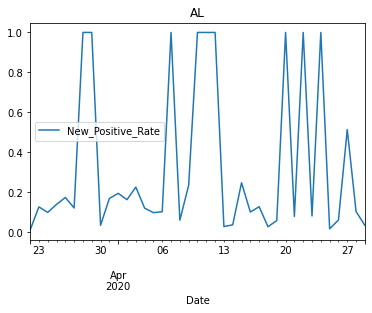

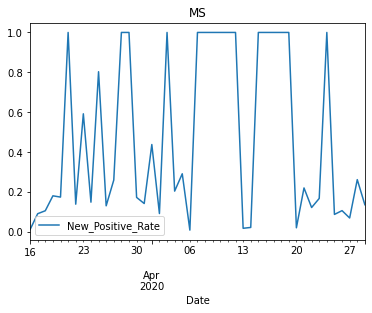

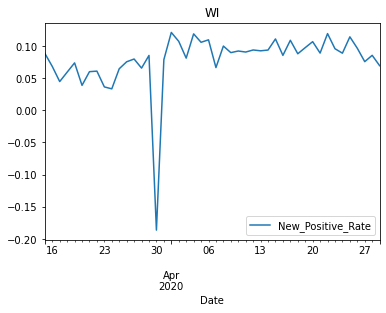

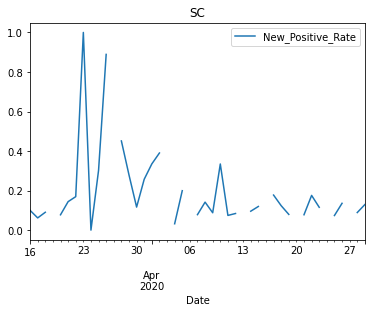

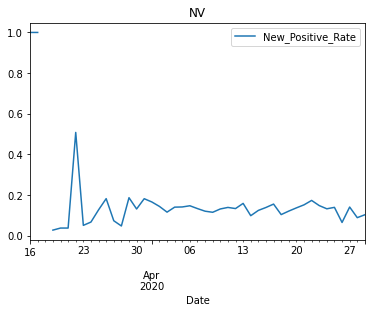

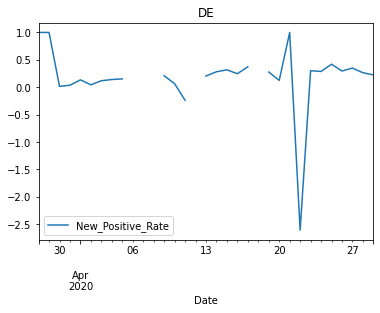

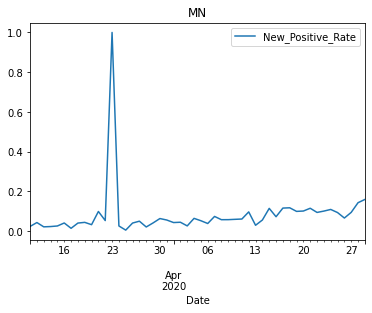

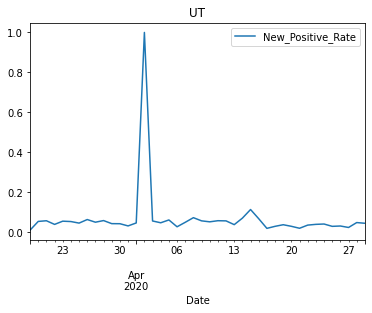

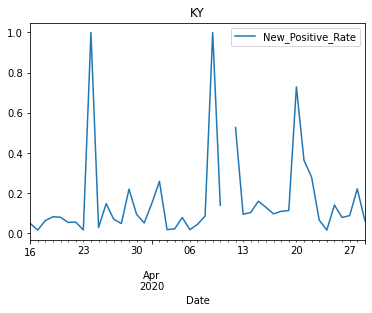

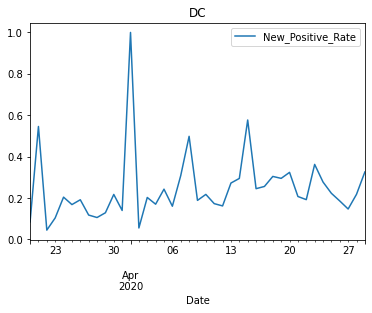

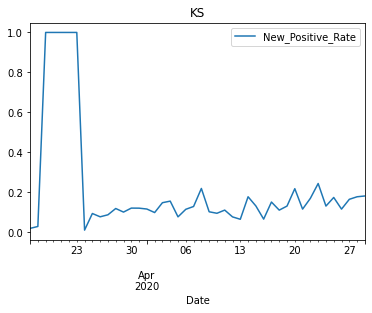

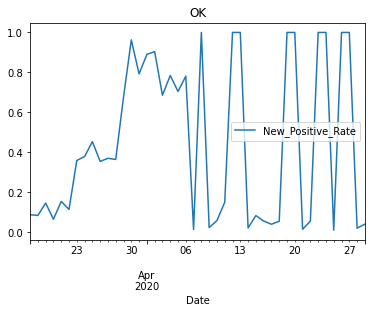

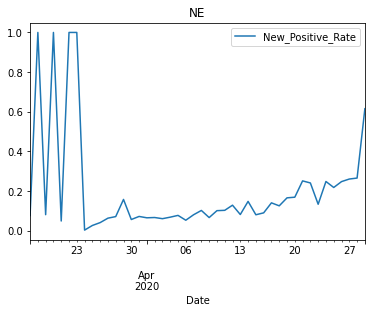

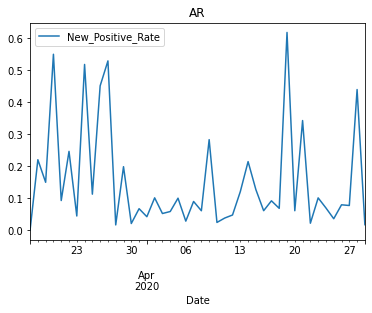

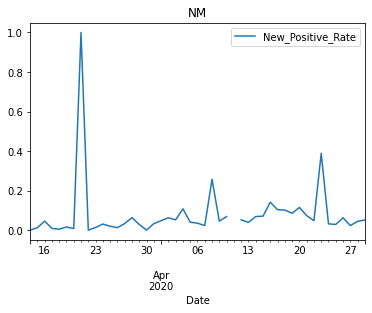

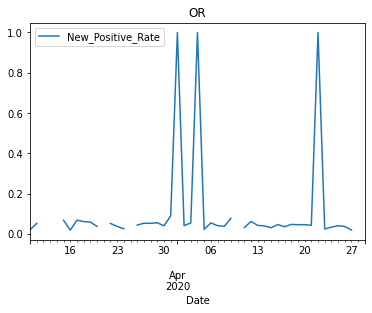

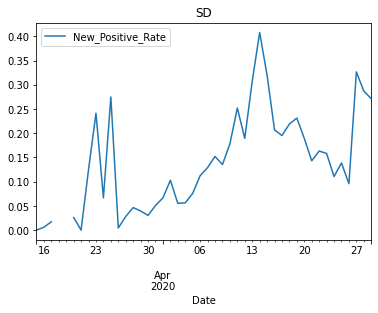

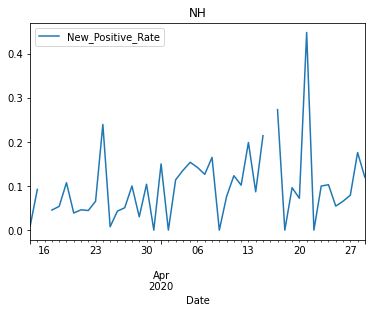

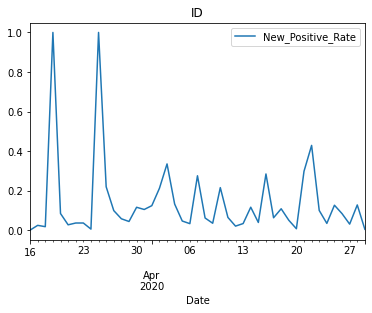

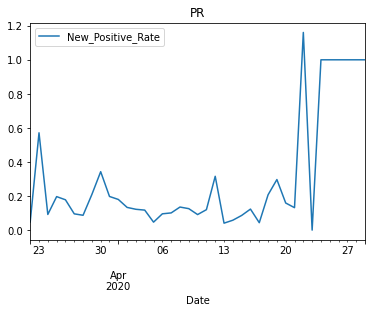

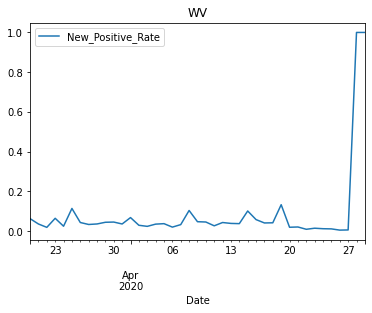

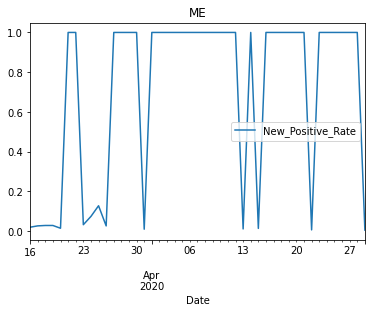

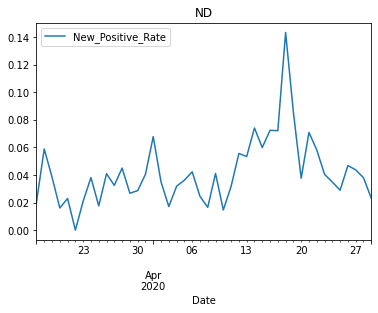

In [14]:
# Plot time series of fraction of NEW tests that are positive, by state
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  df[df.Total>200][['Date',
                    'New_Positive_Rate']].set_index('Date').plot(y='New_Positive_Rate', 
                                                                 title=state)
  plt.show()

In [15]:
# Show mean fraction of cumulative positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# It's noteworthy that most of the standard deviations are small compared to the means
#    and that the means vary quite a lot by state.
# So within-state results (for positive rate) are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
OR     0.050479  0.004295
ND     0.031824  0.007510
WV     0.034622  0.009226
MN     0.041754  0.012187
KY     0.072376  0.012565
WA     0.069487  0.012612
WI     0.077292  0.012728
NM     0.032905  0.014404
NC     0.066816  0.015993
ME     0.056633  0.017496
NH     0.075934  0.020510
IN     0.174704  0.021527
TX     0.083912  0.021757
KS     0.094786  0.026188
RI     0.117753  0.027216
PR     0.133018  0.028288
NE     0.082998  0.028626
ID     0.079318  0.028955
FL     0.108974  0.029524
IL     0.181088  0.033186
NV     0.108229  0.037502
SC     0.126611  0.037758
DC     0.166185  0.037947
VA     0.116781  0.039936
CO     0.175993  0.040696
AR     0.098369  0.043958
PA     0.153498  0.046792
SD     0.074311  0.048046
UT     0.060927  0.053637
MS     0.133237  0.053646
IA     0.105873  0.054707
TN     0.092987  0.054876
CA     0.128829  0.059592
MA     0.171191  0.061730
NY     0.351361  0.067287
LA     0.201689  0.075733
CT     0.246013  0.075830
GA     0.229877  0.122962
MO     0.139713  0.131059
OK     0.153875  0.131509
MI     0.368975  0.133754
NJ     0.504692  0.135122
AZ     0.148092  0.142309
AL     0.184974  0.186716
OH     0.190097  0.200212
MD     0.288566  0.245374
DE     0.291324  0.249875

In [16]:
# Show mean fraction of DAILY positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# These are less dramatic than the previous table, but still tend to show
#    that within-state results are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df.sort_values(['State','Date']).copy()
df['New_Positives'] = df['Positive'].diff()  # Kluge because it's wrong when the state changes
df['New_Negatives'] = df['Negative'].diff()  #   but OK because we use only after 3/16
df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
df = df[df.Date>'2020-03-16'][['Date', 'New_Positive_Rate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.New_Positive_Rate.agg(['mean', 'std']).sort_values('std')

mean       std
State                    
ND     0.041917  0.024496
WI     0.078774  0.046515
FL     0.103984  0.052409
WA     0.091542  0.060079
IL     0.200441  0.066298
IN     0.195875  0.069353
PA     0.189361  0.074225
MA     0.208915  0.079804
NH     0.101164  0.085051
CO     0.206345  0.088876
VA     0.159927  0.089355
SD     0.148301  0.101859
NY     0.354107  0.120995
MN     0.089018  0.144890
NV     0.149791  0.150821
NM     0.082266  0.158844
DC     0.251487  0.163414
AR     0.151729  0.165689
NJ     0.547313  0.188085
TX     0.143434  0.200686
NC     0.140756  0.205194
WV     0.084907  0.206405
ID     0.144303  0.212648
SC     0.199632  0.213778
RI     0.190523  0.226114
KY     0.168047  0.230501
GA     0.281792  0.233367
UT     0.112189  0.243553
TN     0.155174  0.248508
CT     0.355572  0.252496
OR     0.116110  0.255291
MI     0.343744  0.259713
NE     0.208171  0.272806
IA     0.233864  0.286298
KS     0.220608  0.286460
AZ     0.269263  0.292595
LA     0.283340  0.299656
PR     0.278197  0.343825
MD     0.406521  0.351483
MO     0.275064  0.354692
CA     0.348214  0.365538
OH     0.367829  0.395158
OK     0.448867  0.401865
MS     0.481354  0.419904
AL     0.399313  0.423041
ME     0.713918  0.447244
DE     0.404504  0.633966

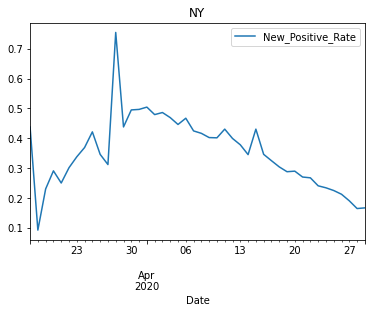

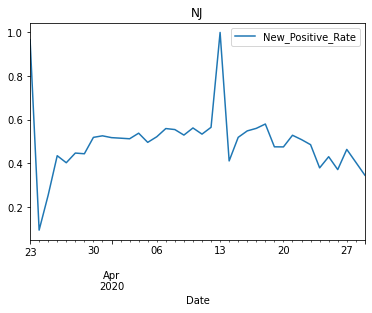

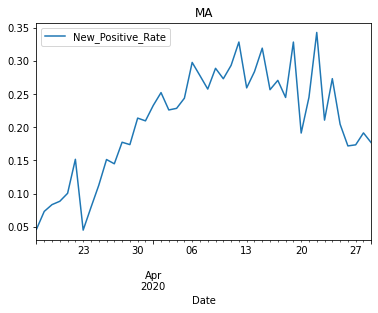

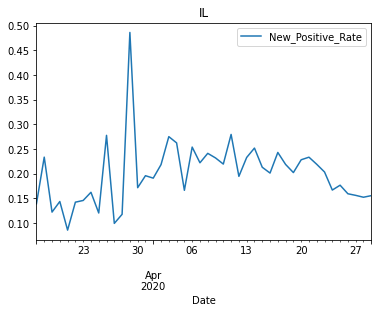

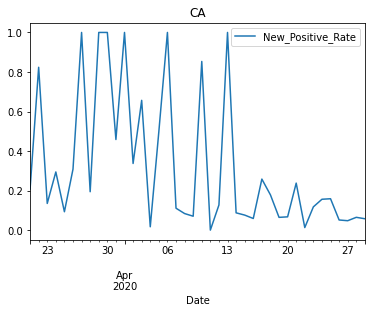

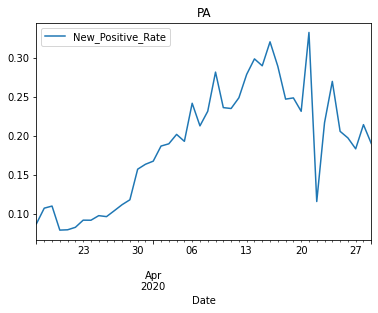

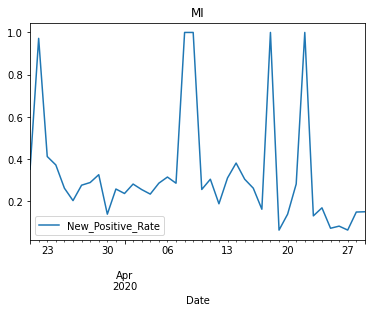

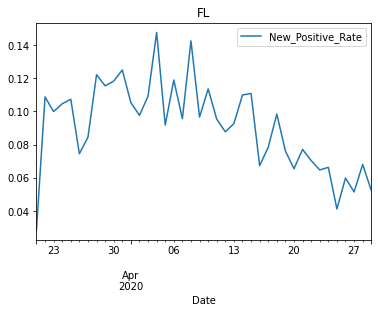

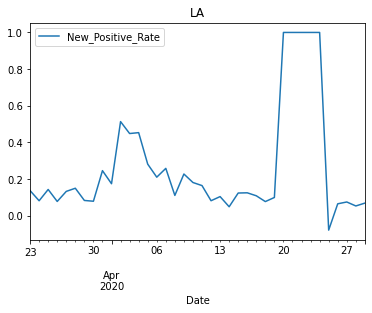

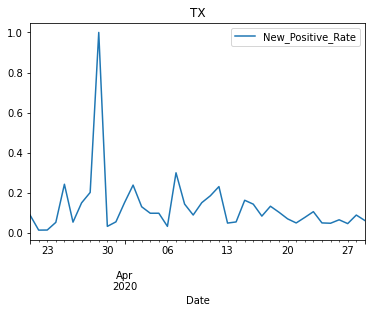

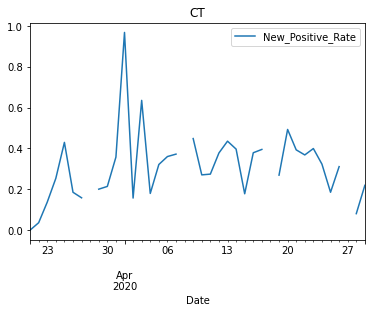

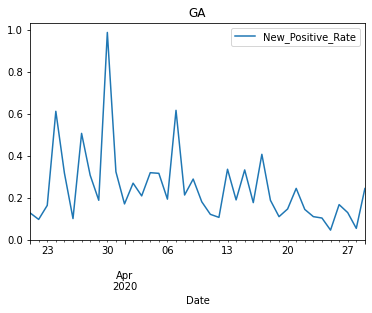

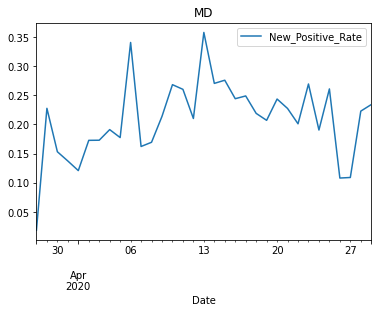

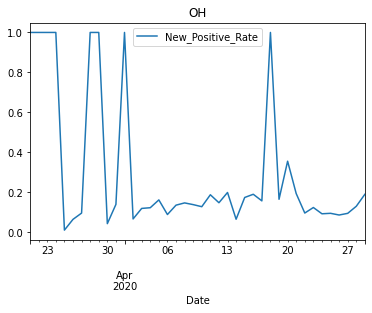

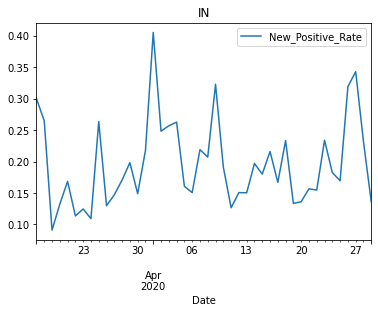

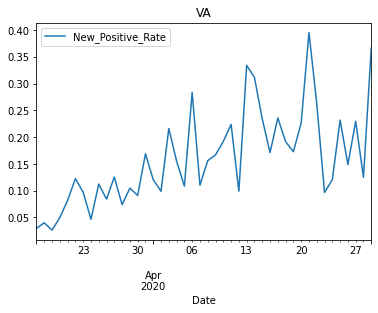

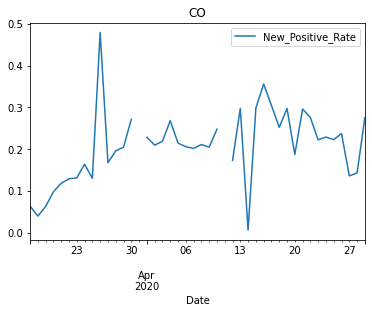

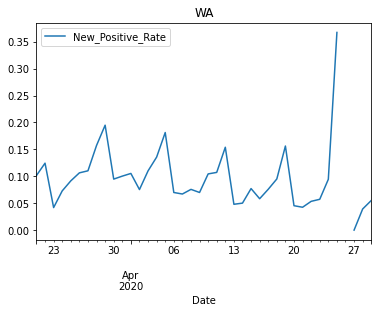

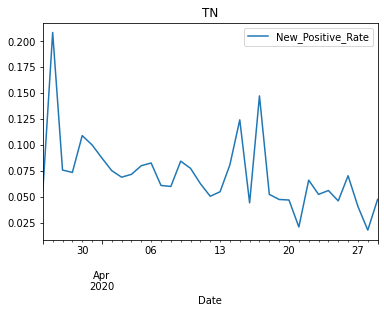

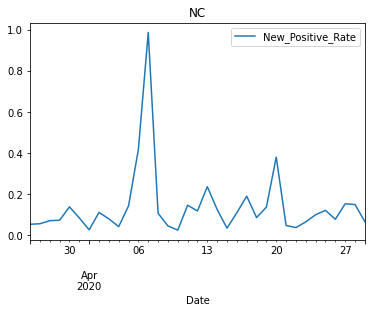

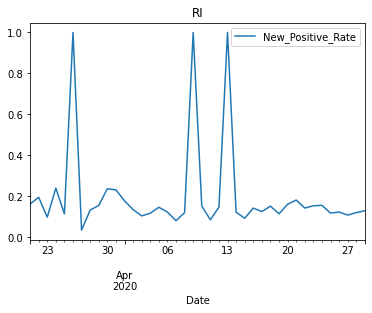

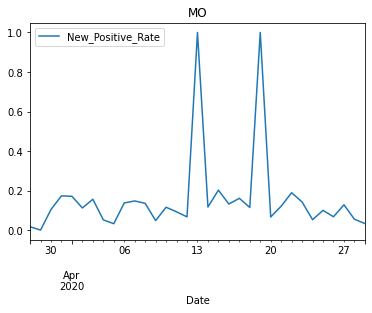

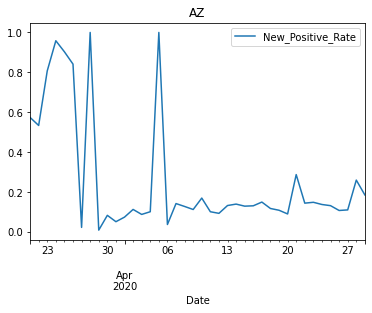

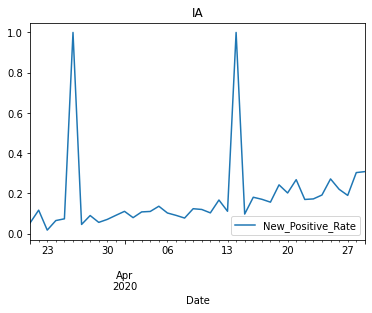

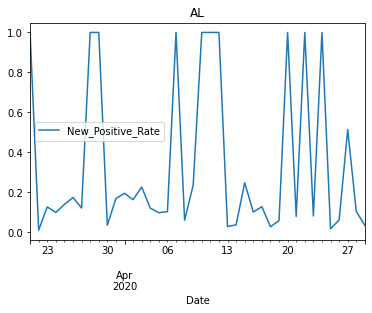

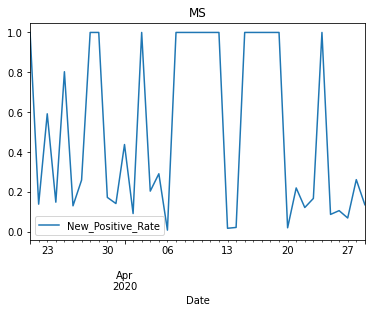

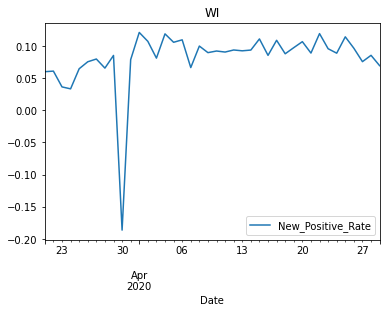

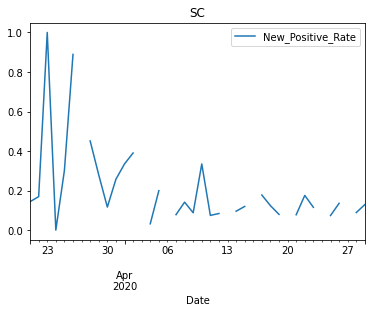

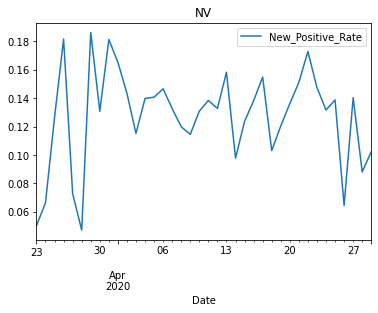

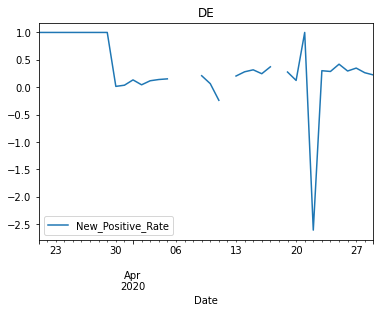

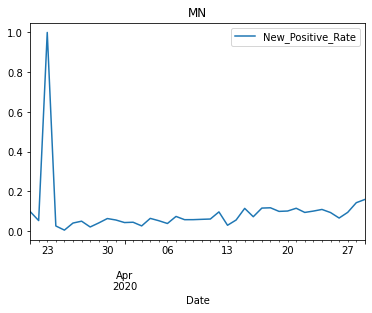

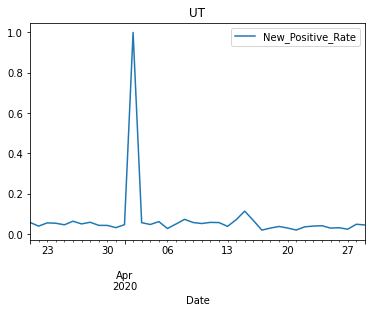

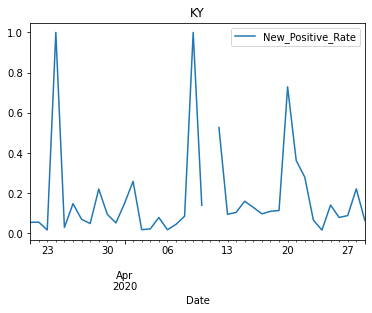

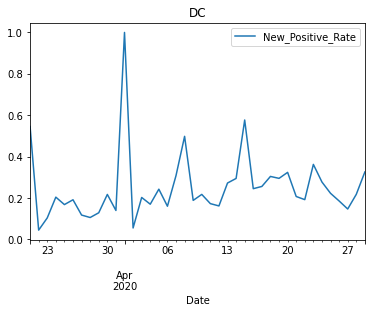

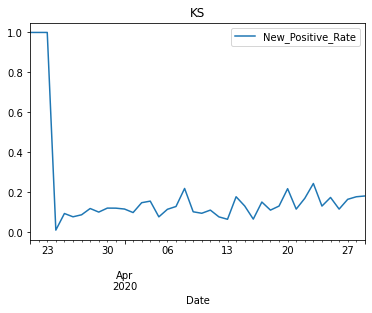

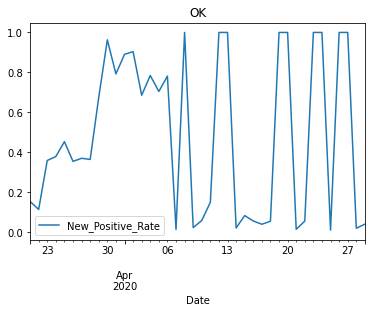

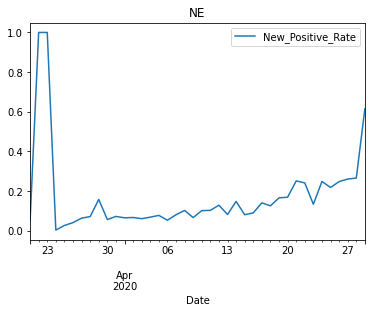

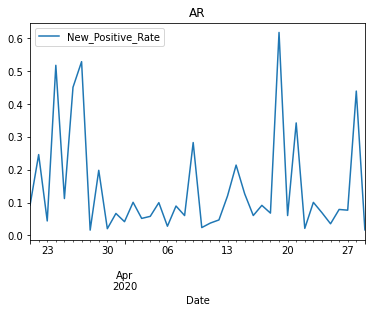

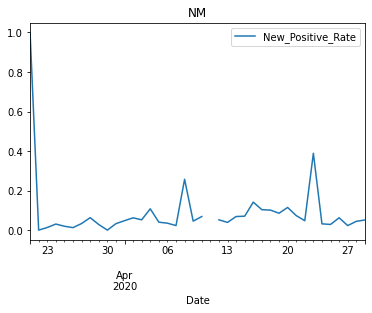

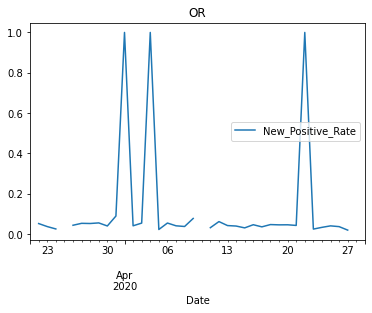

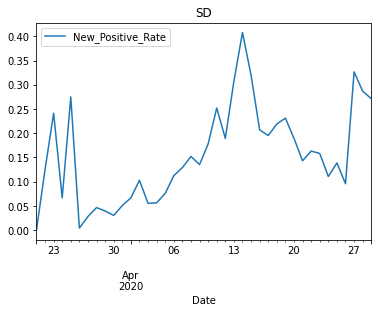

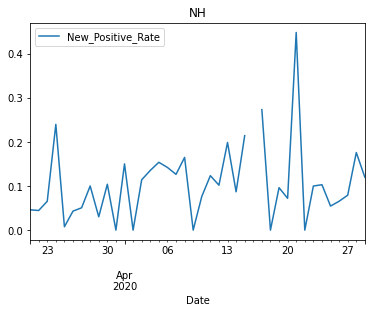

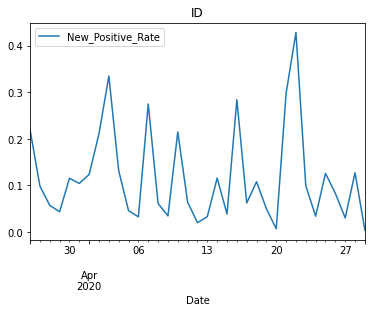

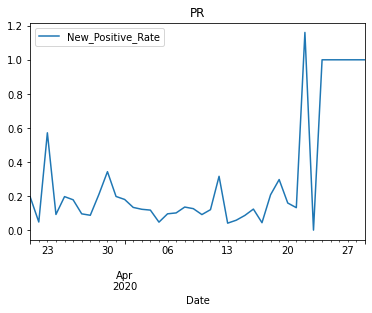

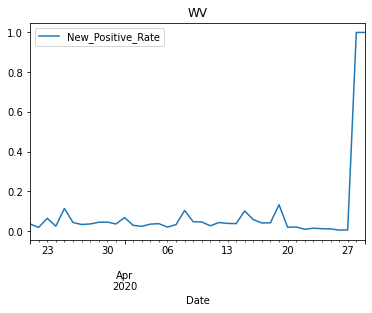

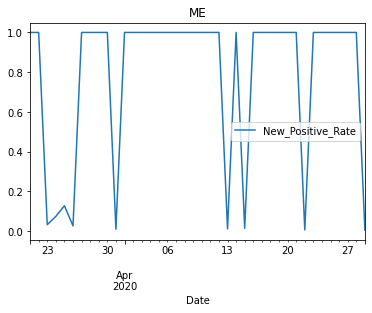

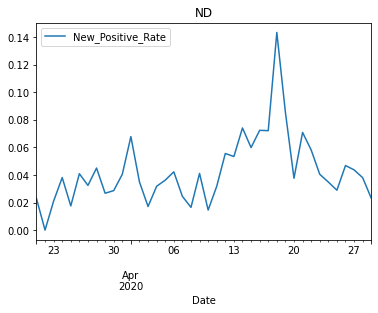

In [17]:
# Plot time series of fraction of NEW tests that are positive, by state,
#   with different start dates for different states, 
#   because positive rates stabilized at different times
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'
                             ).plot(y='New_Positive_Rate', title=state)
  plt.show()